In [2]:
from IPython.core.display import HTML
HTML("""<style>
div.text_cell_render { /* Customize text cells */
font-size:1.1em;
line-height:1.4em;
}
</style>""")

In [6]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import dlib
import os, pickle

## Apply FaceNet to an image

We'll use a pre-trained convolutional neural network on a subset of MS-Celebs-1M dataset (the dataset actually contains 100K celebs at this point). 

To generate the embedding we need to do the following steps:

1. Read an image
- Detect a face rectangle using Dlib face detector
- Crop the face, and possibly rotate and stretch it to fit the required dimensions of 160x160.
- Feed the cropped and aligned face image from the previous step into the network, and obtain the embedding.

In [55]:
# Download and extract the pre-trained TensorFlow FaceNet network, if needed.
import requests, zipfile, bz2

def download_file(url, local_filename):
    os.makedirs(os.path.dirname(local_filename), exist_ok=True)
    r = requests.get(url, headers={'User-Agent': 'curl/7.48.0', 'accept': '*/*'})
    with open(local_filename, 'wb') as f:
        f.write(r.content)
    return r.content

def download_facenet():
    local_filename = 'models/20170216-091149.zip'
    if not os.path.exists('models/20170216-091149/model-20170216-091149.meta'):
        download_file('https://www.dropbox.com/s/xlk7v6nr7bxy2yd/20170216-091149.zip', local_filename)
        with zipfile.ZipFile(local_filename, 'r') as zip_file:
            zip_file.extractall('models')
    if os.path.exists(local_filename): 
        os.remove(local_filename)
        
def download_dlib():
    dlib_dir = 'models/dlib'
    local_filename = dlib_dir + '/shape_predictor_68_face_landmarks.dat'
    if not os.path.exists(local_filename):
        content = download_file('http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2', local_filename + '.bz2')
        with open(local_filename, 'wb') as f:
            f.write(bz2.decompress(content))
    if os.path.exists(local_filename + '.bz2'):
        os.remove(local_filename + '.bz2')
        
download_facenet()
download_dlib()

## Detect face

In [56]:
from align.align_dlib import AlignDlib
align = AlignDlib('models/dlib/shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()

def detect_face(path):
    image = mpimg.imread(path)
    bbs = detector(image, 1)
    tuples = []
    for r in bbs:
        tuples.append((r.left(), r.top(), r.right(), r.bottom()))
    return tuples, image

In [57]:
def draw_rects(image, rects):
    result = image.copy()
    for left, top, right, bottom in rects:
        cv2.rectangle(result, (left, top), (right, bottom), (0, 255, 0), 2)
    return result

CPU times: user 100 ms, sys: 39.3 ms, total: 139 ms
Wall time: 232 ms


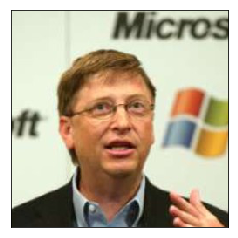

In [58]:
%time rects, image = detect_face('lfw_subset/Bill_Gates/Bill_Gates_0015.jpg')
plt.xticks([])
plt.yticks([])
plt.imshow(image)

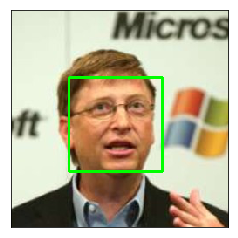

In [59]:
plt.xticks([])
plt.yticks([])
plt.imshow(draw_rects(image, rects))

## Align face

In [60]:
EXPECT_SIZE = 160

def align_face(image, face_box, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE):
    assert isinstance(face_box, tuple)
    face_rect = dlib.rectangle(*face_box)
    landmarks = align.findLandmarks(image, face_rect)
    alignedFace = align.align(EXPECT_SIZE, image, face_rect, 
                              landmarks=landmarks,
                              landmarkIndices=landmarkIndices)
    return alignedFace

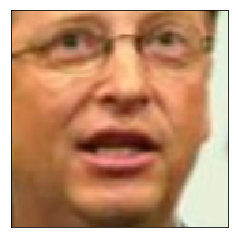

In [61]:
aligned_face = align_face(image, rects[0], AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
plt.xticks([])
plt.yticks([])
plt.imshow(aligned_face)

## Load the model

In [62]:
from os import path

def load_model(model_meta, model_content):
    s = tf.InteractiveSession()
    saver = tf.train.import_meta_graph(model_meta)
    saver.restore(s, model_content)
    tf.get_default_graph().as_graph_def()
    return s

In [63]:
session = load_model('models/20170216-091149/model-20170216-091149.meta', 
                     'models/20170216-091149/model-20170216-091149.ckpt-250000')

In [64]:
graph = tf.get_default_graph()
image_batch = graph.get_tensor_by_name("input:0")
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
embeddings = graph.get_tensor_by_name("embeddings:0")

## Apply the model

In [68]:
feed_dict = { 
            image_batch: np.expand_dims(aligned_face, 0), # (160, 160, 3) -> (1, 160, 160, 3)
            phase_train_placeholder: False }

CPU times: user 457 ms, sys: 60.6 ms, total: 518 ms
Wall time: 178 ms
[ -1.77746519e-01  -6.84664845e-02  -2.64017731e-01  -7.22493529e-02
   9.66365114e-02  -8.58600587e-02   9.54257101e-02   2.04081945e-02
  -7.87477475e-03   1.27218068e-01  -1.44380867e-01  -2.21371129e-02
  -1.89939812e-02   1.83577109e-02   5.76783624e-03   3.24003282e-03
   4.25819010e-02   2.80631557e-02   1.62020013e-01  -1.66002318e-01
  -1.42768808e-02   6.17247596e-02  -7.62104541e-02   3.43886227e-03
   8.85597467e-02   2.81075537e-02  -1.10724449e-01   3.43332104e-02
  -8.92054569e-03   1.65273305e-02  -6.71110451e-02  -2.23370758e-03
   2.15387065e-02   4.59390087e-03   1.31265655e-01   1.63732335e-01
  -1.20731637e-01  -9.60119963e-02   2.45076008e-02  -1.91379607e-01
  -1.05845831e-01   1.49548762e-02   1.08026296e-01   3.39140669e-02
   1.05440304e-01   2.86613088e-02   9.01687965e-02   7.73866475e-02
   8.36347193e-02  -2.87701488e-02   6.24734797e-02  -1.90066099e-01
   6.68680817e-02   1.03498839e-0

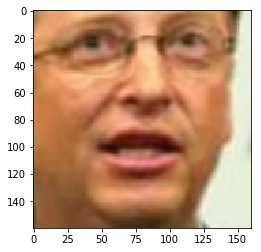

In [72]:
%time rep = session.run(embeddings, feed_dict=feed_dict)[0]
print(rep)
print(np.linalg.norm(rep))
plt.imshow(aligned_face)

## Pipeline to apply to sets of images

In [70]:
def rep_for_image_path(session, image_path):
    global image_batch, phase_train_placeholder, embeddings
    
    tuples, face_orig = detect_face(image_path)
    if len(rects) > 0:
        face = align_face(face_orig, rects[0])
        feed_dict = { 
            image_batch: np.expand_dims(face, 0), 
            phase_train_placeholder: False }
    
        rep = session.run(embeddings, feed_dict=feed_dict)
    else:
        rep = None
    return rep

def reps_for_person(dir_name):
    all = []
    file_names = []

    for fname in os.listdir(dir_name):
        rep = rep_for_image_path(session, dir_name + '/' + fname)
        if rep is not None:
            all.append(rep[0])
            file_names.append(fname)
    return np.array(all), file_names

def load_people_faces(dir_path, person_paths):
    assert isinstance(person_paths, list)
    result = []
    all_file_names = []
    for person_path in person_paths:
        full_path = dir_path + '/' + person_path
        reps, file_names = reps_for_person(full_path)
        result.append(reps)
        all_file_names.append(file_names)
    return np.array(result), all_file_names

We will load image sets for two people (e.g. Bill Gates, and Britney Spears), and use linear discriminant analysis to project the resuling points onto 2-d place for display. Linear discriminant analysis works similarly to principal component analysis, but optimizes for the highest separation of the two labeled datasets. 

In [55]:
names = ['Bill_Gates', 'Britney_Spears']
people, _ = load_people_faces('lfw_subset', names)

In [47]:
def people_to_classes(people):
    all = np.concatenate(tuple(people))
    classes = []
    prev = 0
    for class_id, p in enumerate(people):
        length = p.shape[0]
        this_class = np.empty(length).astype(np.int)
        this_class[:] = int(class_id)
        classes.extend(this_class)
    return all, np.array(classes)

In [56]:
X, classes = people_to_classes(people)
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen', shrinkage='auto')
people_lda = lda.fit(X, classes).transform(X)
print(X.shape, classes.shape, people_lda.shape)

(32, 128) (32,) (32, 2)


### Draw results

Display the embeddings corresponding to the images of two different people. Ideally, we will be able to see two clear clusters, one for each person.

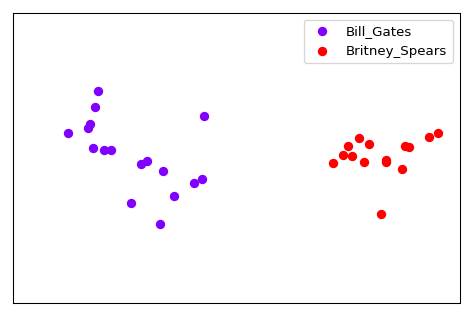

In [58]:
import matplotlib.cm as cm

plt.figure(dpi=96) # Make the chart bigger
plt.xticks([])
plt.yticks([])

# A set of points for each person gets its own color
colors = cm.rainbow(np.linspace(0, 1, len(people)))
plots = []
prev = 0
for p, color in zip(people, colors):
    person_lda = people_lda[prev:prev+p.shape[0]]
    prev = p.shape[0]
    # Split the (x, y) array into two arrays: x and y
    x, y = tuple(np.split(person_lda, 2, axis=1))
    plots.append(plt.scatter(x, y, color=color))
    plt.legend(plots, names, loc='best', shadow=False, scatterpoints=1)